# Dependencies

In [1]:
import os, warnings, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 160)

In [2]:
# Preprocess data
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
    text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()\

# Preprocess inputs
CLS = 0
PAD = 1
SEP = 2

def preprocess_roberta(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][:max_seq_len]
    attention_mask = encoded['attention_mask'][:max_seq_len]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def preprocess_roberta_tail(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    if len(encoded['input_ids']) > max_seq_len:
        return x
    else:
        return None

def preprocess_roberta_tail_test(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def get_data(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    y_data_int = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        if x is not None:
            x_input_ids.append(x[0])
            x_attention_masks.append(x[1])

            y_data.append(getattr(row, 'toxic'))
            y_data_int.append(getattr(row, 'toxic_int'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = [np.asarray(y_data, dtype=np.float32), 
              np.asarray(y_data_int, dtype=np.int8)]
    
    return x_data, y_data

def get_data_test(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])


    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    return x_data

# Parameters

In [3]:
MAX_LEN = 224
tokenizer_path = 'jplu/tf-xlm-roberta-large'
sample_rate = 2

# Load data

In [4]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])
test_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv", usecols=['content'])


n_neg_samp_df1 = len(train1.query('toxic > .5')) * sample_rate
n_neg_samp_df2 = len(train2.query('toxic > .5')) * sample_rate

train_df = pd.concat([train1[['comment_text', 'toxic']].query('toxic > .5'),
                      train1[['comment_text', 'toxic']].query('toxic <= .5').sample(n=n_neg_samp_df1, random_state=SEED),
                      train2[['comment_text', 'toxic']].query('toxic > .5'),
                      train2[['comment_text', 'toxic']].query('toxic <= .5').sample(n=n_neg_samp_df2, random_state=SEED)
                    ])

print(f'Dataframe 1 samples: toxic|non-toxic | {n_neg_samp_df1 // sample_rate}|{n_neg_samp_df1}')
print(f'Dataframe 2 samples: toxic|non-toxic | {n_neg_samp_df2 // sample_rate}|{n_neg_samp_df2}')
print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())
print('Validation samples %d' % len(valid_df))
display(valid_df.head())
display(valid_df.describe())
print('Test samples %d' % len(test_df))
display(test_df.head())
display(test_df.describe())

Dataframe 1 samples: toxic|non-toxic | 21384|42768
Dataframe 2 samples: toxic|non-toxic | 112226|224452
Train samples 400830


,comment_text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any on...",1.0
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1.0
42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holoc...",1.0
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1.0


,toxic
count,400830.000000
mean,0.289194
std,0.356484
min,0.000000
25%,0.000000
50%,0.000000
75%,0.600000
max,1.000000


Validation samples 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo ...,es,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, nel fare cio .",it,0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nivel particular. Las volveria a pasar putas...",es,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siyaset bilimi ana başlığından sonra siyasa...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecekte(2-3 yıl) bu tip şeyler düşünüyorum. T...,tr,0


,toxic
count,8000.000000
mean,0.153750
std,0.360731
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Test samples 63812


,content
0,Doctor Who adlı viki başlığına 12. doctor olarak bir viki yazarı kendi adını eklemiştir. Şahsen düzelttim. Onaylarsanız sevinirim. Occipital
1,"Вполне возможно, но я пока не вижу необходимости выделять материал в отдельную статью. Если про правосудие в СССР будет написано хотя бы килобайт 20-30 — т..."
2,"Quindi tu sei uno di quelli conservativi , che preferiscono non cancellare. Ok. Avresti lasciato anche sfaccimma ? Si? Ok. Contento te... io non appro..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı. Belki yararlanırsınız. İyi çalışmalar. Kud yaz Teşekkür ederim. Abidenin maddesini de geni...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu :Resim:Seldabagcan.jpg resmini yüklediğiniz için teşekkürler. Ancak dosyanın tanım sayfasında içeriğin k...


,content
count,63812
unique,63812
top,"chupame la pija, mogolico down hijo de puta sidoso y pajero!!! gracias y pedite una eutanasia, negra puta latina berreta... sidosita"
freq,1


# Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, lowercase=False)

## Preprocess

In [6]:
# Train
train_df['comment_text'] = train_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
train_df['length'] = train_df['comment_text'].apply(lambda x : len(x))
train_df['word_count'] = train_df['comment_text'].apply(lambda x : len(x.split(' ')))
train_df['token_count'] = train_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))
train_df['toxic_int'] = train_df['toxic'].round().astype(int)

# Validation
valid_df['comment_text'] = valid_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
valid_df['length'] = valid_df['comment_text'].apply(lambda x : len(x))
valid_df['word_count'] = valid_df['comment_text'].apply(lambda x : len(x.split(' ')))
valid_df['token_count'] = valid_df['comment_text'].apply(lambda x : len(tokenizer.encode(x)))
valid_df['toxic_int'] = valid_df['toxic'].round().astype(int)

# Test
test_df['content'] = test_df.apply(lambda x: clean_text(x['content']), axis=1)
test_df['length'] = test_df['content'].apply(lambda x : len(x))
test_df['word_count'] = test_df['content'].apply(lambda x : len(x.split(' ')))
test_df['token_count'] = test_df['content'].apply(lambda x : len(tokenizer.encode(x)))

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())
print('Validation samples %d' % len(valid_df))
display(valid_df.head())
display(valid_df.describe())
print('Test samples %d' % len(test_df))
display(test_df.head())
display(test_df.describe())

Train samples 400830


,comment_text,toxic,length,word_count,token_count,toxic_int
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1.0,44,8,19,1
12,Hey what is it talk What is it an exclusive group of some WP TALIBANS who are good at destroying self appointed purist who GANG UP any one who asks them que...,1.0,295,54,74,1
16,Bye Don t look come or think of comming back Tosser,1.0,51,11,16,1
42,You are gay or antisemmitian Archangel WHite Tiger Meow Greetingshhh Uh there are two ways why you do erased my comment about WW that holocaust was brutally...,1.0,607,116,158,1
43,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1.0,38,8,16,1


,toxic,length,word_count,token_count,toxic_int
count,400830.000000,400830.000000,400830.000000,400830.000000,400830.000000
mean,0.289194,282.127448,52.003233,64.894387,0.333333
std,0.356484,322.182691,58.705995,77.271527,0.471405
min,0.000000,0.000000,1.000000,2.000000,0.000000
25%,0.000000,85.000000,16.000000,22.000000,0.000000
50%,0.000000,181.000000,34.000000,43.000000,0.000000
75%,0.600000,370.000000,68.000000,84.000000,1.000000
max,1.000000,5000.000000,2142.000000,2754.000000,1.000000


Validation samples 8000


,comment_text,lang,toxic,length,word_count,token_count,toxic_int
0,Este usuario ni siquiera llega al rango de hereje Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediant...,es,0,213,37,52,0
1,Il testo di questa voce pare esser scopiazzato direttamente da qui Immagino possano esserci problemi di copyright nel fare cio,it,0,126,20,30,0
2,Vale Sólo expongo mi pasado Todo tiempo pasado fue mejor ni mucho menos yo no quisiera retroceder años a nivel particular Las volveria a pasar putas Fernando,es,1,157,27,35,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var Önerim siyaset bilimi ana başlığından sonra siyasal ...,tr,0,382,51,83,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın Ben de uzak gelecekte yıl bu tip şeyler düşünüyorum Tabii fu...,tr,0,398,53,90,0


,toxic,length,word_count,token_count,toxic_int
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.153750,347.909375,54.747500,81.757750,0.153750
std,0.360731,259.152636,38.982345,58.002811,0.360731
min,0.000000,0.000000,1.000000,2.000000,0.000000
25%,0.000000,163.000000,26.000000,41.000000,0.000000
50%,0.000000,261.000000,42.000000,62.000000,0.000000
75%,0.000000,445.000000,70.000000,102.000000,0.000000
max,1.000000,1615.000000,312.000000,704.000000,1.000000


Test samples 63812


,content,length,word_count,token_count
0,Doctor Who adlı viki başlığına doctor olarak bir viki yazarı kendi adını eklemiştir Şahsen düzelttim Onaylarsanız sevinirim Occipital,133,18,35
1,Вполне возможно но я пока не вижу необходимости выделять материал в отдельную статью Если про правосудие в СССР будет написано хотя бы килобайт тогда да сле...,445,73,100
2,Quindi tu sei uno di quelli conservativi che preferiscono non cancellare Ok Avresti lasciato anche sfaccimma Si Ok Contento te io non approvo per nulla ma n...,268,49,66
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı Belki yararlanırsınız İyi çalışmalar Kud yaz Teşekkür ederim Abidenin maddesini de genişletmeyi düşünüy...,600,82,135
4,Resim Seldabagcan jpg resminde kaynak sorunu Resim Seldabagcan jpg resmini yüklediğiniz için teşekkürler Ancak dosyanın tanım sayfasında içeriğin kimin tara...,1458,178,296


,length,word_count,token_count
count,63812.000000,63812.000000,63812.000000
mean,356.644487,58.018272,85.219645
std,265.534902,41.684450,61.944336
min,0.000000,1.000000,2.000000
25%,162.000000,27.000000,41.000000
50%,267.000000,44.000000,65.000000
75%,465.000000,76.000000,110.000000
max,7749.000000,845.000000,3848.000000


## Filter

In [7]:
train_df = train_df[train_df['word_count'] <= 250]
train_df = train_df[train_df['token_count'] <= 1000]
train_df = shuffle(train_df, random_state=SEED).reset_index(drop=True)

print('Train samples %d' % len(train_df))
display(train_df.head())
display(train_df.describe())

Train samples 398295


,comment_text,toxic,length,word_count,token_count,toxic_int
0,I agree give Clinton another shot in it s just what the Democratic Party needs she could pick Nancy Pelosi as her running mate they would be unstoppable tog...,0.0,161,29,34,0
1,It s my understanding that BC has quietly advised Mr Kenney they are ready willing to build that wall he wants and they ll pay for it too,0.0,137,28,34,0
2,Bill we also have a policy called WP BOLD You do not have to wait for any particular person to approve your edit before you make them You could go ahead wit...,0.0,604,121,129,0
3,He s absolutely right though Trudeau is selling us out,0.0,54,10,14,0
4,eyesnore faggot of the year,1.0,27,5,10,1


,toxic,length,word_count,token_count,toxic_int
count,398295.000000,398295.000000,398295.000000,398295.000000,398295.000000
mean,0.289446,267.518149,49.361717,61.279275,0.333866
std,0.355933,250.810313,45.462005,54.561857,0.471593
min,0.000000,0.000000,1.000000,2.000000,0.000000
25%,0.000000,84.000000,16.000000,21.000000,0.000000
50%,0.000000,179.000000,34.000000,42.000000,0.000000
75%,0.600000,364.000000,67.000000,82.000000,1.000000
max,1.000000,4965.000000,250.000000,999.000000,1.000000


# Data generation sanity check

In [8]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 32
    comment_text = train_df['comment_text'].loc[idx]
    
    x_train, y_train = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('label         : "%.4f"' % y_train[0])
    print('label int     : "%d"'   % y_train[1])
    print('comment_text  : "%s"'   % comment_text)
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    
    x_train, _ = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta_tail)
    if len(x_train[0]) > 0:
        print('-------------------- TAIL --------------------')

        print('input_ids     : "%s"' % x_train[0][0])
        print('attention_mask: "%s"' % x_train[1][0])

        assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len


Row 0
label         : "0.0000"
label int     : "0"
comment_text  : "I agree give Clinton another shot in it s just what the Democratic Party needs she could pick Nancy Pelosi as her running mate they would be unstoppable together"
input_ids     : "[     0     87  53520   8337  56485  15700  51876     23    442     91
   1660   2367     70 182017  31016  27117   2412   5809  39580 156946
 100457    172    237    604  51042  29968   1836   2806    186     51
  76824      2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"
-------------------- TAIL --------------------
input_ids     : "[     0   8337  56485  15700  51876     23    442     91   1660   2367
     70 182017  31016  27117   2412   5809  39580 156946 100457    172
    237    604  51042  29968   1836   2806    186     51  76824   2886
  25842      2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"

Row 1
label         : "0.0000"
label int     : "0"
comment

# 5-Fold split

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['toxic_int'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 318636, Validation size 79659
Fold: 2, Train size: 318636, Validation size 79659
Fold: 3, Train size: 318636, Validation size 79659
Fold: 4, Train size: 318636, Validation size 79659
Fold: 5, Train size: 318636, Validation size 79659


# Label distribution

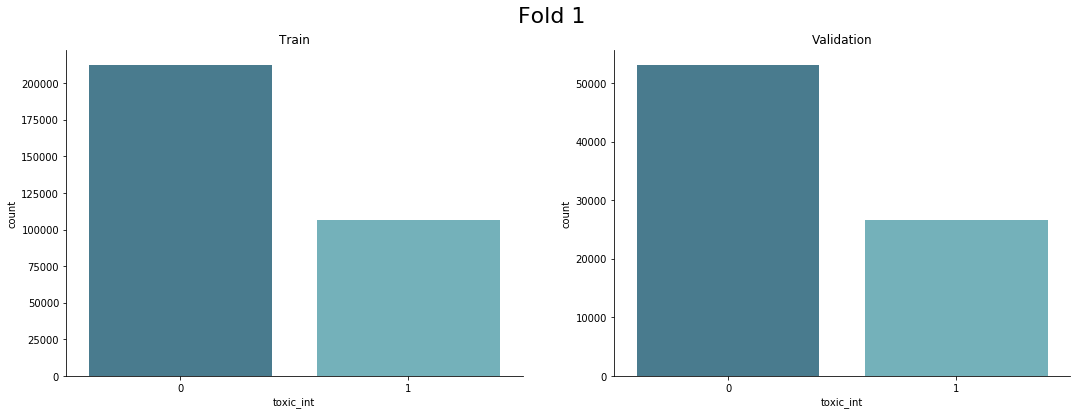

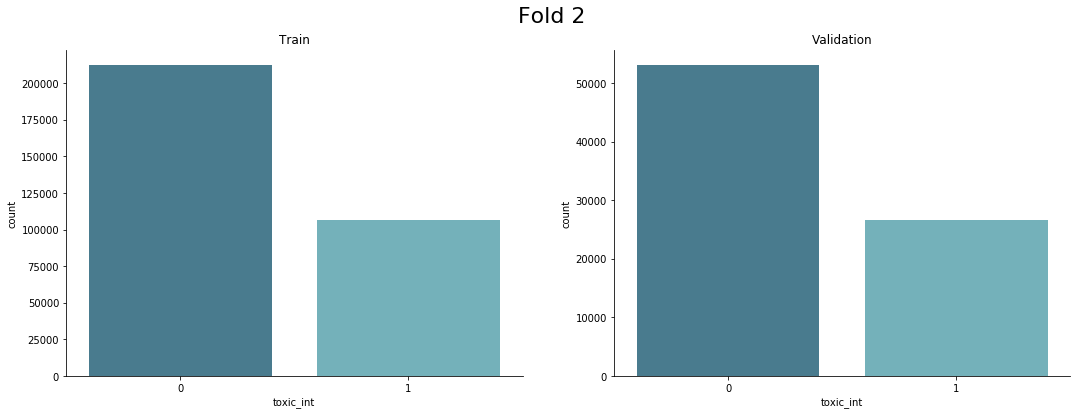

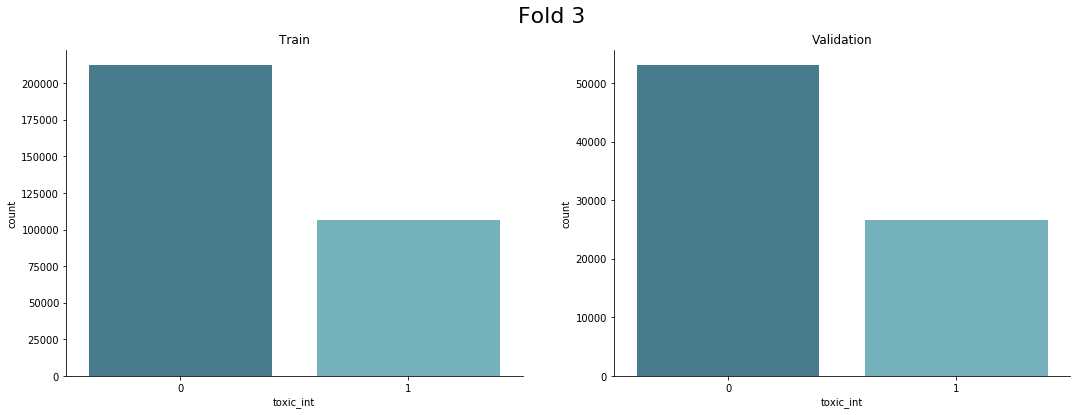

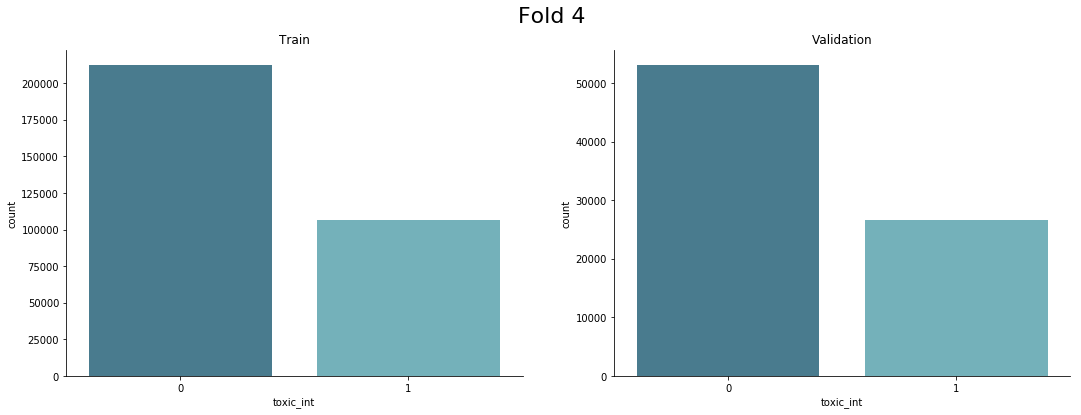

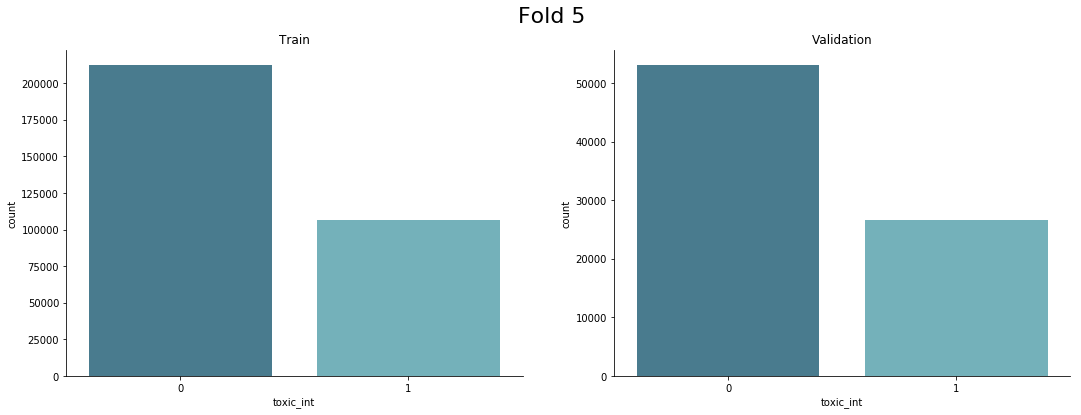

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

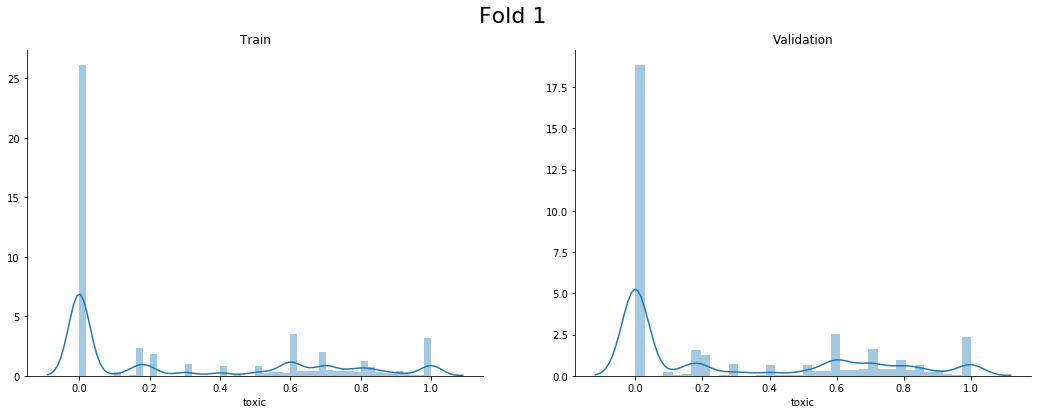

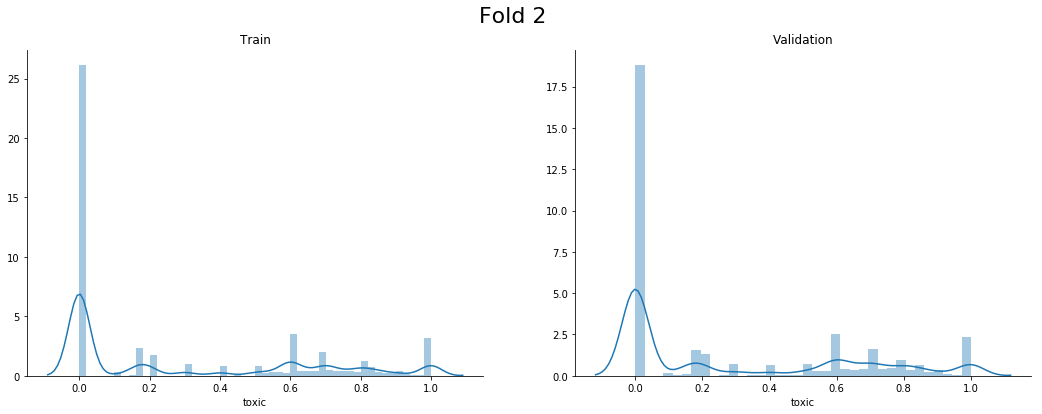

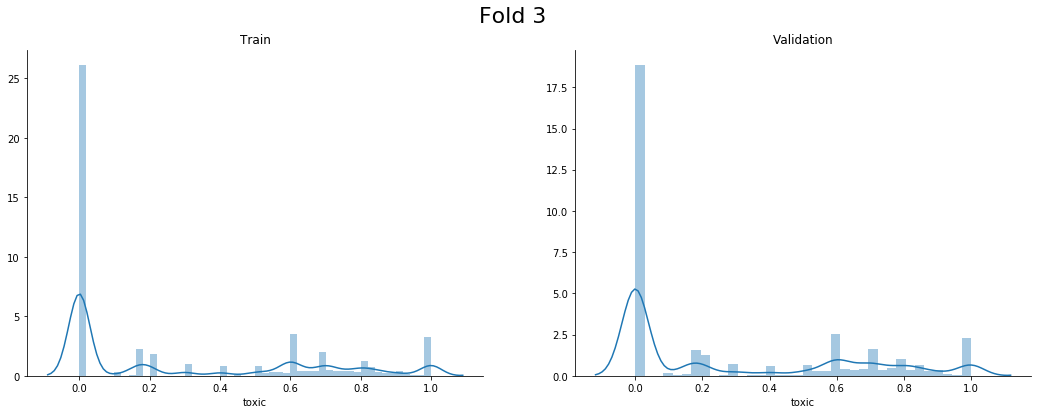

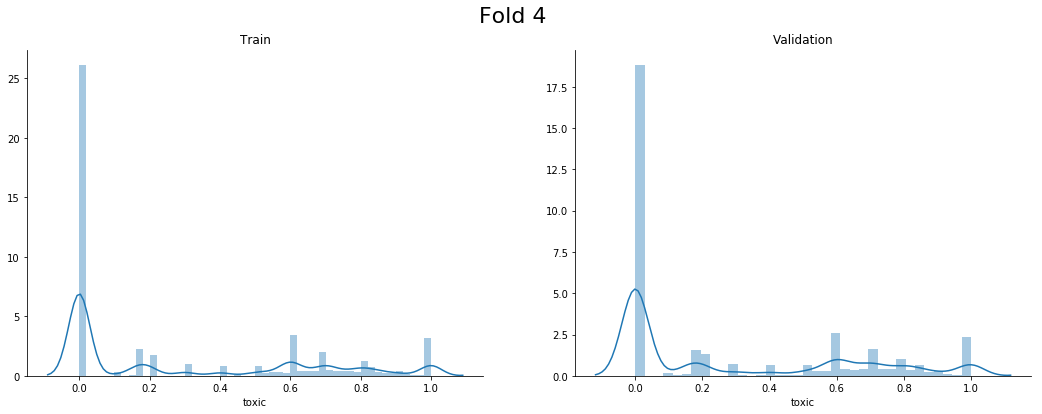

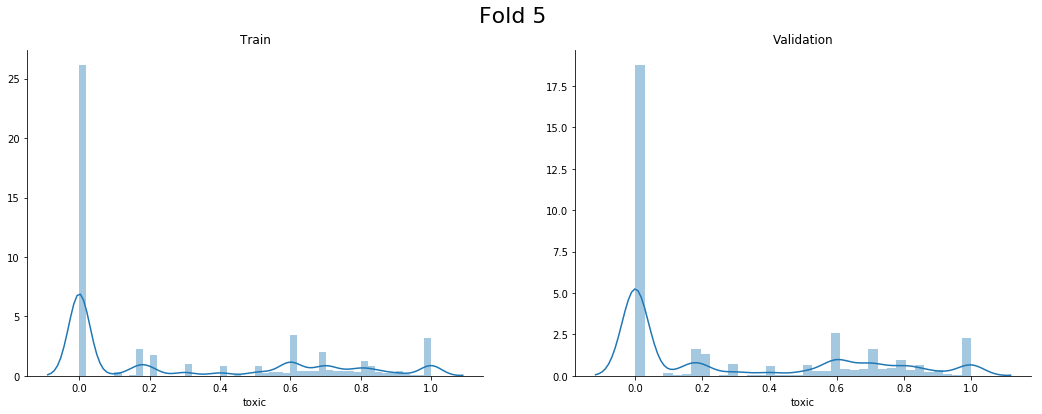

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['toxic'], ax=ax1).set_title('Train')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['toxic'], ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [12]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    if fold_n < 1:
        fold_n += 1
        base_path = 'fold_%d/' % fold_n

        # Create dir
        os.makedirs(base_path)

        x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        y_train_float, y_train_int = y_train
        y_valid_float, y_valid_int = y_valid
        x_train, y_train_float, y_train_int =  np.asarray(x_train), np.asarray(y_train_float), np.asarray(y_train_int)
        x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)
        
        np.save(base_path + 'x_train', x_train)
        np.save(base_path + 'y_train', y_train_float)
        np.save(base_path + 'y_train_int', y_train_int)
        np.save(base_path + 'x_valid', x_valid)
        np.save(base_path + 'y_valid', y_valid_float)
        np.save(base_path + 'y_valid_int', y_valid_int)

        print('\nFOLD: %d' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train_float shape:', y_train_float.shape)
        print('y_train_int shape:', y_train_int.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid_float shape:', y_valid_float.shape)
        print('y_valid_int shape:', y_valid_int.shape)
        
        #################### ENCODE TAIL ONLY ####################

        x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        y_train_float, y_train_int = y_train
        y_valid_float, y_valid_int = y_valid
        x_train, y_train_float, y_train_int =  np.asarray(x_train), np.asarray(y_train_float), np.asarray(y_train_int)
        x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)
        
        np.save(base_path + 'x_train_tail', x_train)
        np.save(base_path + 'y_train_tail', y_train_float)
        np.save(base_path + 'y_train_int_tail', y_train_int)
        np.save(base_path + 'x_valid_tail', x_valid)
        np.save(base_path + 'y_valid_tail', y_valid_float)
        np.save(base_path + 'y_valid_int_tail', y_valid_int)

        print('\nFOLD: %d [TAIL]' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train_float shape:', y_train_float.shape)
        print('y_train_int shape:', y_train_int.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid_float shape:', y_valid_float.shape)
        print('y_valid_int shape:', y_valid_int.shape)

#  Compress logs dir
!tar -czf fold_1.tar.gz fold_1
# !tar -czf fold_2.tar.gz fold_2
# !tar -czf fold_3.tar.gz fold_3
# !tar -czf fold_4.tar.gz fold_4
# !tar -czf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
# shutil.rmtree('fold_2')
# shutil.rmtree('fold_3')
# shutil.rmtree('fold_4')
# shutil.rmtree('fold_5')

,comment_text,toxic,length,word_count,token_count,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,I agree give Clinton another shot in it s just what the Democratic Party needs she could pick Nancy Pelosi as her running mate they would be unstoppable tog...,0.0,161,29,34,0,train,validation,train,train,train
1,It s my understanding that BC has quietly advised Mr Kenney they are ready willing to build that wall he wants and they ll pay for it too,0.0,137,28,34,0,train,train,validation,train,train
2,Bill we also have a policy called WP BOLD You do not have to wait for any particular person to approve your edit before you make them You could go ahead wit...,0.0,604,121,129,0,train,train,validation,train,train
3,He s absolutely right though Trudeau is selling us out,0.0,54,10,14,0,train,train,train,train,validation
4,eyesnore faggot of the year,1.0,27,5,10,1,train,train,validation,train,train



FOLD: 1
x_train shape: (2, 318636, 224)
y_train_float shape: (318636,)
y_train_int shape: (318636,)
x_valid shape: (2, 79659, 224)
y_valid_float shape: (79659,)
y_valid_int shape: (79659,)

FOLD: 1 [TAIL]
x_train shape: (2, 2220, 224)
y_train_float shape: (2220,)
y_train_int shape: (2220,)
x_valid shape: (2, 526, 224)
y_valid_float shape: (526,)
y_valid_int shape: (526,)


# Validation set

In [13]:
display(valid_df.head())
display(valid_df.describe())

x_valid, y_valid = get_data(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
y_valid_float, y_valid_int = y_valid
x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)

np.save('x_valid', x_valid)
np.save('y_valid', y_valid_float)
np.save('y_valid_int', y_valid_int)
print('x_valid shape:', x_valid.shape)
print('y_valid_float shape:', y_valid_float.shape)
print('y_valid_int shape:', y_valid_int.shape)

#################### ENCODE TAIL ONLY ####################

x_valid, y_valid = get_data(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
y_valid_float, y_valid_int = y_valid
x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)

np.save('x_valid_tail', x_valid)
np.save('y_valid_tail', y_valid_float)
np.save('y_valid_int_tail', y_valid_int)
print('x_valid shape:', x_valid.shape)
print('y_valid_float shape:', y_valid_float.shape)
print('y_valid_int shape:', y_valid_int.shape)

,comment_text,lang,toxic,length,word_count,token_count,toxic_int
0,Este usuario ni siquiera llega al rango de hereje Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediant...,es,0,213,37,52,0
1,Il testo di questa voce pare esser scopiazzato direttamente da qui Immagino possano esserci problemi di copyright nel fare cio,it,0,126,20,30,0
2,Vale Sólo expongo mi pasado Todo tiempo pasado fue mejor ni mucho menos yo no quisiera retroceder años a nivel particular Las volveria a pasar putas Fernando,es,1,157,27,35,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var Önerim siyaset bilimi ana başlığından sonra siyasal ...,tr,0,382,51,83,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın Ben de uzak gelecekte yıl bu tip şeyler düşünüyorum Tabii fu...,tr,0,398,53,90,0


,toxic,length,word_count,token_count,toxic_int
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.153750,347.909375,54.747500,81.757750,0.153750
std,0.360731,259.152636,38.982345,58.002811,0.360731
min,0.000000,0.000000,1.000000,2.000000,0.000000
25%,0.000000,163.000000,26.000000,41.000000,0.000000
50%,0.000000,261.000000,42.000000,62.000000,0.000000
75%,0.000000,445.000000,70.000000,102.000000,0.000000
max,1.000000,1615.000000,312.000000,704.000000,1.000000


x_valid shape: (2, 8000, 224)
y_valid_float shape: (8000,)
y_valid_int shape: (8000,)
x_valid shape: (2, 276, 224)
y_valid_float shape: (276,)
y_valid_int shape: (276,)


# Test set

In [14]:
display(test_df.head())
display(test_df.describe())

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_test = np.asarray(x_test)

np.save('x_test', x_test)
print('x_test shape:', x_test.shape)

#################### ENCODE TAIL ONLY ####################

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail_test)
x_test = np.asarray(x_test)

np.save('x_test_tail', x_test)
print('[TAIL] x_test shape:', x_test.shape)

,content,length,word_count,token_count
0,Doctor Who adlı viki başlığına doctor olarak bir viki yazarı kendi adını eklemiştir Şahsen düzelttim Onaylarsanız sevinirim Occipital,133,18,35
1,Вполне возможно но я пока не вижу необходимости выделять материал в отдельную статью Если про правосудие в СССР будет написано хотя бы килобайт тогда да сле...,445,73,100
2,Quindi tu sei uno di quelli conservativi che preferiscono non cancellare Ok Avresti lasciato anche sfaccimma Si Ok Contento te io non approvo per nulla ma n...,268,49,66
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı Belki yararlanırsınız İyi çalışmalar Kud yaz Teşekkür ederim Abidenin maddesini de genişletmeyi düşünüy...,600,82,135
4,Resim Seldabagcan jpg resminde kaynak sorunu Resim Seldabagcan jpg resmini yüklediğiniz için teşekkürler Ancak dosyanın tanım sayfasında içeriğin kimin tara...,1458,178,296


,length,word_count,token_count
count,63812.000000,63812.000000,63812.000000
mean,356.644487,58.018272,85.219645
std,265.534902,41.684450,61.944336
min,0.000000,1.000000,2.000000
25%,162.000000,27.000000,41.000000
50%,267.000000,44.000000,65.000000
75%,465.000000,76.000000,110.000000
max,7749.000000,845.000000,3848.000000


x_test shape: (2, 63812, 224)
[TAIL] x_test shape: (2, 63812, 224)


# Test set EDA

## Word count distribution

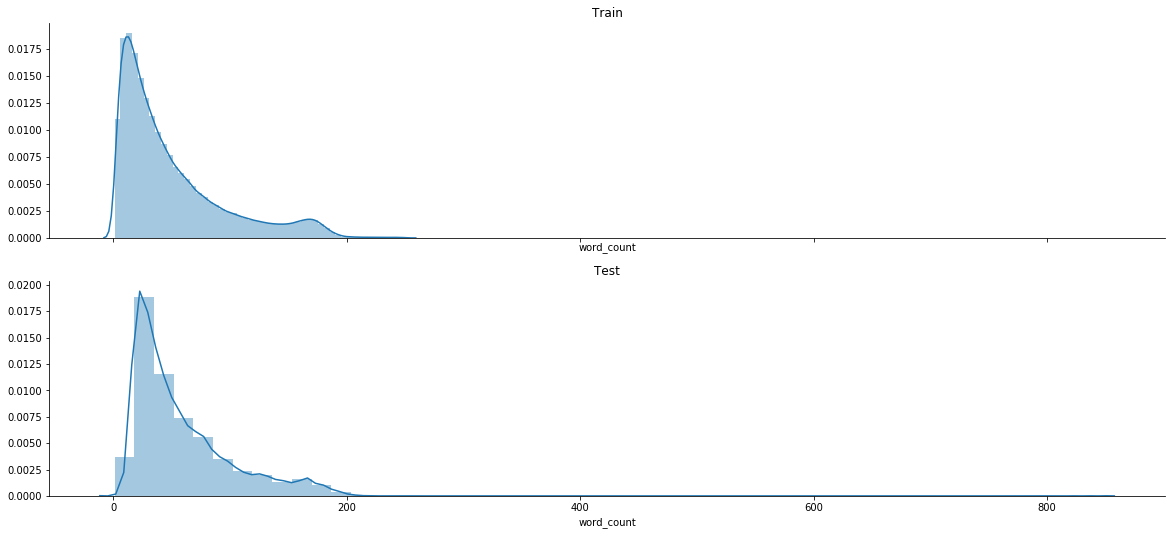

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['word_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['word_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()

## Token count distribution

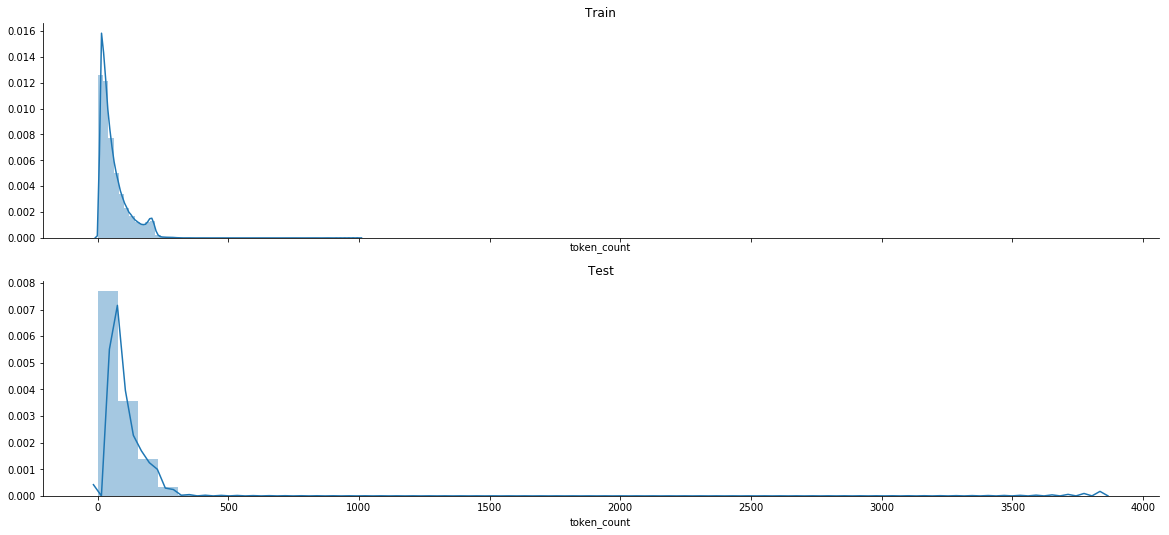

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(train_df['token_count'], ax=ax1).set_title("Train")
sns.distplot(test_df['token_count'], ax=ax2).set_title("Test")
sns.despine()
plt.show()